@article{diode_dataset,
  title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
  author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and
  Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and
  Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
  journal={CoRR},
  volume={abs/1908.00463},
  year={2019},
  url={http ://arxiv.org/abs/1908.00463}
}

In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(24)

In [2]:
annotation_folder = "/data/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 87s 0us/step


In [3]:
path = '/content/val/outdoor'

In [4]:
paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        paths.append(os.path.join(root, file))

In [5]:
paths = np.sort(paths)

In [6]:
len(paths)

1338

In [21]:
def enhance_depth_map1(depth_map , mask):
  depth_map = np.load(depth_map).squeeze()
  mask = np.load(mask)
  mask = mask > 0
  max_depth = min(300, np.percentile(depth_map, 99))
  depth_map = np.clip(depth_map, 0.1, max_depth)
  depth_map = np.log(depth_map, where=mask)
  depth_map = np.ma.masked_where(~mask, depth_map)
  depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
  depth_map = cv2.resize(depth_map, (512, 512))
  depth_map = np.expand_dims(depth_map, axis=2)
  depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
  return depth_map

In [22]:
from skimage import exposure

def enhance_depth_map2(depth_map_path, mask_path):
    # Load depth map and mask data
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, 0.1, max_depth)
    enhanced_depth_map = exposure.equalize_hist(depth_map, mask=mask)
    resized_depth_map = cv2.resize(enhanced_depth_map, (512, 512))
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)
    return converted_depth_map


In [9]:
def multi_scale_retinex(img, sigma_list, G, b, alpha, low_clip, high_clip):
    img = np.float64(img) + 1.0

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(img, (G, G), sigma)
        retinex = retinex + np.log10(img) - np.log10(gaussian)

    retinex = alpha * retinex

    retinex = np.where(retinex < low_clip, low_clip, retinex)
    retinex = np.where(retinex > high_clip, high_clip, retinex)

    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex)) * 255
    retinex = np.uint8(retinex)

    return retinex

def enhance_depth_map_retinex(depth_map_path, mask_path, target_size=(512, 512), sigma_list=(15, 80, 250), G=15, b=25, alpha=125, low_clip=0, high_clip=255):
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    enhanced_depth_map = multi_scale_retinex(depth_map, sigma_list, G, b, alpha, low_clip, high_clip)
    resized_depth_map = cv2.resize(enhanced_depth_map, target_size)
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)

    return converted_depth_map


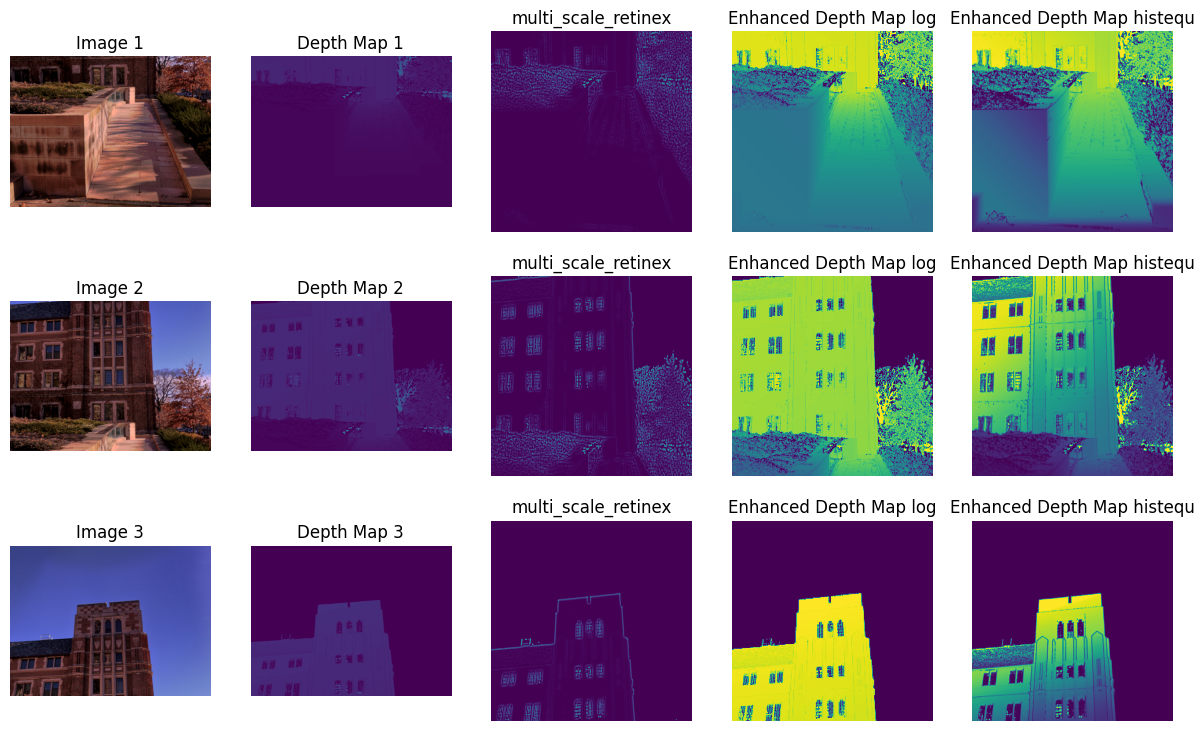

In [10]:
image_paths = [paths[i] for i in range(0 , 8 , 3)]  # Example image paths
depth_arrays = [np.load(paths[i+1]) for i in range(0 , 8 , 3)]
depth_mask_arrays = [np.load(paths[i+2]) for i in range(0 , 8 , 3)]
depth1 = [enhance_depth_map1(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth2 = [enhance_depth_map2(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth3 = [enhance_depth_map_retinex(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]

fig, axes = plt.subplots(len(image_paths), 5, figsize=(15, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(len(image_paths)):
    image = plt.imread(image_paths[i])

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth_arrays[i], cmap='viridis')
    axes[i, 1].set_title('Depth Map {}'.format(i + 1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(depth3[i], cmap='viridis')
    axes[i, 2].set_title('multi_scale_retinex')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(depth1[i], cmap='viridis')
    axes[i, 3].set_title('Enhanced Depth Map log')
    axes[i, 3].axis('off')

    axes[i, 4].imshow(depth2[i], cmap='viridis')
    axes[i, 4].set_title('Enhanced Depth Map histequ')
    axes[i, 4].axis('off')



plt.show()


so the hist Histogram Equalization is choosed

# in progress...

In [15]:
files = []
depth_files = []
mask_files = []
for i in range(0 , len(paths)-2 , 3):
  files.append(paths[i])
  depth_files.append(paths[i+1])
  mask_files.append(paths[i+2])

In [16]:
len(files) , len(depth_files) , len(mask_files)

(446, 446, 446)

In [20]:
np.load(mask_files[0]).shape

(768, 1024)

In [46]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_images, list_depth_maps, list_masks, batch_size=20, dim=(512, 512), n_channels=1, shuffle=True):
        """
        Initialization
        """
        self.list_images = list_images
        self.indices = range(len(self.list_images))
        self.list_depth_maps = list_depth_maps
        self.list_masks = list_masks
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.dim = dim
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(len(self.list_images) / float(self.batch_size)))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_path, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = enhance_depth_map2(depth_path , mask)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.list_images[batch_id],
                self.list_depth_maps[batch_id],
                self.list_masks[batch_id],
            )

        return x, y

In [50]:
data_generator = CustomDataGenerator(files , depth_files , mask_files, batch_size=20 ,dim=(512, 512), n_channels=3, shuffle=True)

# Access batches using data_generator[i]
# Example:
batch_images, batch_depth_maps =  data_generator.__getitem__(0)

In [51]:
batch_images.shape , batch_depth_maps.shape

((20, 512, 512, 3), (20, 512, 512, 1))

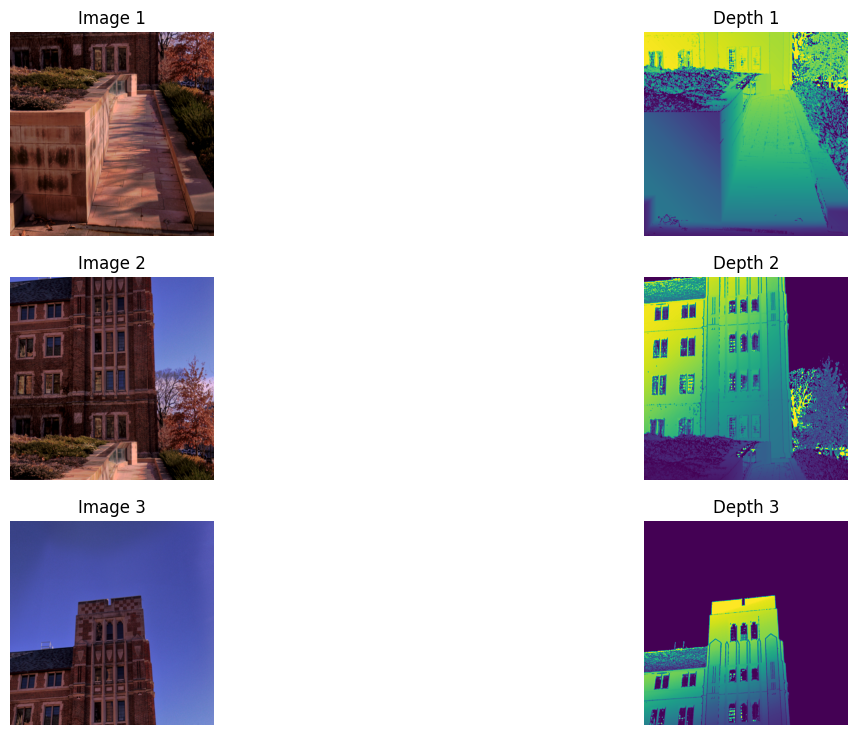

In [55]:
import matplotlib.pyplot as plt

# Assuming you have imported the necessary modules and obtained the data as shown previously

# Visualize the first image and its corresponding depth map
image_to_visualize = batch_images[:3]
depth_map_to_visualize = batch_depth_maps[:3]

fig, axes = plt.subplots(3, 2, figsize=(15, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(3):
    axes[i, 0].imshow(batch_images[i])
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch_depth_maps[i])
    axes[i, 1].set_title('Depth {}'.format(i + 1))
    axes[i, 1].axis('off')
